In [73]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import graphviz
import seaborn as sns

from time import time
from copy import deepcopy
from sklearn.preprocessing import normalize

### To do 

* Fix add_edge()
* Implement coevolution

* Implement master function

* Imeplement analysis metrics

In [306]:
class Population:
    def __init__(self, population_size):
        self.population_size = population_size
        self.hosts = [Host() for n in range(population_size)]
        
        self.current_generation = 0
        self.generations = [self.hosts]
        self.average_fitness = [] 
    
    def selection(self, threshold=10e-3, selection_seed=np.random.randint(0,1000), verbose=0):
        
        fitness_vector = np.zeros(self.population_size)
        
        for i,host in enumerate(self.hosts):
            host.evolve(parasite_seed=selection_seed, verbose=verbose)
            fitness_vector[i] = host.fitness_host
        
                                  
        print('Generation {}. Average fitness: {}. Best fitness: {}.'.format(self.current_generation, np.mean(fitness_vector), np.max(fitness_vector)))
        self.average_fitness.append(np.mean(fitness_vector))

        fitness_vector = np.array([x for x in fitness_vector if  x > threshold])
        cumulative_fitness = np.cumsum(normalize(fitness_vector.reshape(-1,1), axis=0, norm='l1'))
        #print('Sampling: ',[i for i in cumulative_fitness.searchsorted(np.random.uniform(0, 1, self.population_size))])
        next_gen = [self.hosts[i].reproduce() for i in cumulative_fitness.searchsorted(np.random.uniform(0, 1, self.population_size))]
        
        self.generations.append(next_gen)
        self.hosts = next_gen
        
        self.current_generation += 1

    
class Host:
    def __init__(self):
        self.n_nodes = 6
        self.n_signalers = self.n_nodes - 2
        
        self.network = nx.binomial_graph(directed=True, n=self.n_nodes,p=0.5)
        
        mapping = dict(list(zip(range(n_nodes), ['D']+list(range(n_nodes-2))+['E'])))
        
        self.network = nx.relabel_nodes(self.network, mapping)
                
        for i,node in enumerate(self.network.nodes):
            self.network.nodes[node]['active'] = 0.5
            self.network.nodes[node]['label'] = (['D']+(self.n_nodes-2)*['S']+['E'])[i]
    
        for u,v,e in self.network.edges(data=True):
            e['weight'] = np.random.uniform(-1,1)

        self.network.remove_edges_from([('E','D'),('D','E')])
        
        #to track back for reproduction
        self.architecture = deepcopy(self.network)
        
        self.infected = False
        
    
    
    def update(self):
        network_copy = deepcopy(self.network)

        for node in self.network.nodes:
            dP = 0
            for n in self.network.predecessors(n=node):
                weight = nx.get_edge_attributes(self.network,'weight')[(n,node)] 
                if weight > 0:
                    dP += (1-self.network.node[node]['active'])*weight*self.network.node[n]['active']
                elif weight < 0:
                    dP += self.network.node[node]['active']*weight*self.network.node[n]['active']
            
            if np.isnan(dP):
                print('NAN!')
                print(nx.get_edge_attributes(self.network,'weight'))
                print(nx.get_node_attributes(self.network,'active'))
            
            if network_copy.node[node]['active'] + dP > 1:
                network_copy.node[node]['active'] = 1
            elif network_copy.node[node]['active'] + dP < 0:
                network_copy.node[node]['active'] = 0
            else:
                network_copy.node[node]['active'] += dP
            
            #network_copy.node[node]['active'] = min(1, network_copy.node[node]['active'] + dP) 

        self.network = network_copy
    
    def infect(self, r=0.8, v=2, verbose=0, seed = np.random.randint(0,1000)):
        self.v = 2
        self.network.add_node(node_for_adding='P', active=0.5, label='P')
        self.network.add_weighted_edges_from([('P','D',1.0), ('E','P',-1.0), ('P','P',r)])
        
        np.random.seed(seed=seed)
        
        signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
        
        self.network.nodes['P']['target'] = np.random.choice(signalers)
        
        self.network.nodes['P']['mode'] = np.random.choice(['upreg','downreg'])
        
        self.network.nodes['P']['area'] = 0.5
        self.network.nodes['P']['v'] = 2

        if verbose >= 1:
            print(self.network.nodes['P'])
        
        
        target = self.network.nodes['P']['target']
        
        if self.network.nodes['P']['mode'] == 'downreg':
            self.network.remove_node(target)
        elif self.network.nodes['P']['mode'] == 'upreg':
            self.network.nodes[target]['active'] = 1
            self.network.remove_edges_from([e for e in self.network.edges if e[1] == target])

            for e in [e for e in self.network.edges if e[0] == target]:
                if self.network.edges[e]['weight'] > 0:
                    self.network.edges[e]['weight'] = min(1.0, 2*self.network.edges[e]['weight'])
                else:
                    self.network.edges[e]['weight'] = max(-1.0, 2*self.network.edges[e]['weight'])
    
    def evolve(self, parasite_seed=np.random.randint(0,1000), verbose=0):
        for _ in range(600):
            self.update()
        
        active_pre = self.network.nodes['E']['active']
        self.infect(seed = parasite_seed, verbose = verbose)
        
        for _ in range(600):
            self.update()
            self.network.nodes['P']['area'] += self.network.nodes['P']['active']
        
        active_post = self.network.nodes['E']['active']
        area = round(self.network.nodes['P']['area'] / 600,4)
        v = self.network.nodes['P']['v']
        
        if verbose >= 2:
            print('Active_pre: ', active_pre)
            print('Active_post: ', active_post)
            print('Area: ', area)
        
        self.fitness_host = np.exp(-1*(active_pre + v*area + active_post))
        self.fitness_parasite = np.exp(-1*(2+v)*(1-area))
        
    
    
    def mutate(self, verbose=0):
        """
        25% addition of new allowed edge
        25% deletion of existing edge
        30% alteration of existing edge **
        10% duplication of a protein and all its edges
        10% deletion of a protein and all its edges
        """
        mutation_type = np.random.random()
        
        if mutation_type < 0.25:
            #add allowed edge
            new_architecture = self.new_edge(verbose=verbose)
        
        elif mutation_type < 0.5:
            #remove edge
            new_architecture = self.remove_edge(verbose=verbose)
        
        elif mutation_type < 0.8:
            #alter edge
            new_architecture = self.alter_edge(verbose=verbose)
            
        elif mutation_type < 0.9:
            #duplicate signaler
            new_architecture = self.duplicate_signaler(verbose=verbose) #to do: find out how to increase n_signalers
        else:
            #delete signaler
            new_architecture = self.remove_signaler(verbose=verbose) #to do: find out how to decrease n_signalers
        
        return new_architecture
    
    
    def new_edge(self, verbose=0):
        
        new_architecture = self.architecture
        
        signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
        
        edge_already_exists = True
        
        # to do: optimize!!!!!!!!! search directly from available edges
        while edge_already_exists:

            node1 = np.random.choice(signalers)
            
            node2 = np.random.choice(new_architecture.nodes)

            potential_edge = sorted((node1,node2), key=lambda k: np.random.random())

            for i,node in enumerate(potential_edge):
                try:
                    potential_edge[i] = int(node)
                except:
                    pass


            if potential_edge[0] == potential_edge[1]:
                continue

            if potential_edge not in new_architecture.edges:
                edge_already_exists = False

        new_weight = np.random.uniform(-1.0,1.0)
        new_architecture.add_weighted_edges_from([(potential_edge[0], potential_edge[1], new_weight)])
        
        if verbose >= 1:
            print('New edge: ', potential_edge,' Weight: ', new_weight)
            
        return new_architecture
    
    def remove_edge(self, verbose=0):
        
        new_architecture = self.architecture
        
        if len(new_architecture.edges()) == 0:
            if verbose >= 1:
                print('Warning: cannot remove more edges')
            return new_architecture
        
        edge_index = np.random.randint(0,len(new_architecture.edges()))
        edge_to_remove = list(new_architecture.edges)[edge_index]

        new_architecture.remove_edge(edge_to_remove[0], edge_to_remove[1])
        
        if verbose >= 1:
            print('Edge to remove: ',edge_to_remove)
        
        return new_architecture

    def alter_edge(self, verbose=0):
        
        new_architecture = self.architecture
        
        try:
            edge_index = np.random.randint(0,len(new_architecture.edges()))
            edge_to_alter = list(new_architecture.edges())[edge_index]
            new_architecture.edges[edge_to_alter]['weight'] = np.random.uniform(-1.0,1.0)

            if verbose >= 1:
                print('New weight of ', edge_to_alter, ': ', new_architecture.edges[edge_to_alter]['weight'])
        except:
            pass
        return new_architecture
    
    
    def duplicate_signaler(self, verbose=0):
        
        new_architecture = self.architecture
        
        signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
        
        if len(signalers) >= 8:
            if verbose >= 1:
                print('Warning: cannot add more signalers')
            return new_architecture

        signaler_index = np.random.choice(signalers)
        
        if verbose >= 1:
            print('Signaler to undergo duplication: ', signaler_index)

        new_out_edges =[(max(signalers)+1,v,d['weight']) for u,v,d in new_architecture.edges(data=True) if u == signaler_index]
        new_in_edges = [(u,max(signalers)+1,d['weight']) for u,v,d in new_architecture.edges(data=True) if v == signaler_index]

        new_architecture.add_node(max(signalers)+1)
        new_architecture.add_weighted_edges_from(new_out_edges)
        new_architecture.add_weighted_edges_from(new_in_edges)

        new_architecture.nodes[max(signalers)+1]['label'] = 'S'
        new_architecture.nodes[max(signalers)+1]['active'] = 0.5
        
        return new_architecture
        
    def remove_signaler(self, verbose=0):
        
        new_architecture = self.architecture
        
        signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
        
        if len(signalers) <= 1:
            if verbose >= 1:
                print('Warning: cannot remove more signalers')
            return new_architecture
        
        node_to_remove = np.random.choice(signalers)

        if verbose >= 1:
            print('Signaler to remove: ',node_to_remove)
        
        new_architecture.remove_node(node_to_remove)
        
        return new_architecture
        
    def reproduce(self, p_mutation=5e-3, verbose=0):
        if np.random.random() < p_mutation:
            new_architecture = self.mutate(verbose=verbose)
            new_n_signalers = len([n for n in self.architecture.nodes if n not in ['D','E']])
            
            return HostChild(new_architecture, new_n_signalers)
        
        else:
            if verbose >= 1:
                print('No mutations occurred')
            return HostChild(self.architecture, self.n_signalers)
            
        
    def visualize(self, ax=None):
        
        if ax==None:
            fig, ax = plt.subplots(1)
        
        
        edges,weights = zip(*nx.get_edge_attributes(self.network,'weight').items())

        activating = [e for e,w in nx.get_edge_attributes(self.network,'weight').items() if w > 0]
        positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.network,'weight').items() if w > 0]

        deactivating = [e for e,w in nx.get_edge_attributes(self.network,'weight').items() if w < 0]
        negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.network,'weight').items() if w < 0]
        
        active_ratios = list(nx.get_node_attributes(self.network,'active').values())
        #print(active_ratios)
        
        pos = nx.shell_layout(self.network)

        graph_nodes = nx.draw_networkx_nodes(self.network, node_size=300, pos=pos, alpha=1, ax=ax,
                               node_color= [a for a in active_ratios],
                                            cmap='Greens', vmin=0, vmax=1.5)  

        graph_act_edges =nx.draw_networkx_edges(self.network, edgelist=activating, ax=ax,
                               pos=pos, width=[5*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                                alpha=1)

        graph_deact_edges = nx.draw_networkx_edges(self.network, edgelist=deactivating, ax=ax,
                               pos=pos, width=[5*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                                alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))
        
            
        labels = nx.get_node_attributes(self.network, 'label')

        nx.draw_networkx_labels(self.network, pos=pos, ax=ax,
                               labels = labels)
        nx.draw_networkx_edge_labels(self.network, font_color='#0055FF', label_pos=0.3, ax=ax,
                                    pos=pos, edge_labels=dict(zip(activating,positive_weights)))
        nx.draw_networkx_edge_labels(self.network, font_color='#FF0000', label_pos = 0.3, ax=ax,
                                     pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))
        
        graph_nodes.set_edgecolor('k')

        for e in graph_act_edges+graph_deact_edges:
            e.set_alpha(0.5)
        
        ax.axis('off')
        
        plt.show()
        
        
    def visualize_architecture(self):
        edges,weights = zip(*nx.get_edge_attributes(self.architecture,'weight').items())

        activating = [e for e,w in nx.get_edge_attributes(self.architecture,'weight').items() if w > 0]
        positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.architecture,'weight').items() if w > 0]

        deactivating = [e for e,w in nx.get_edge_attributes(self.architecture,'weight').items() if w < 0]
        negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.architecture,'weight').items() if w < 0]
        
        active_ratios = list(nx.get_node_attributes(self.architecture,'active').values())
        #print(active_ratios)
        
        pos = nx.shell_layout(self.architecture)

        graph_nodes = nx.draw_networkx_nodes(self.architecture, node_size=300, pos=pos, alpha=1, 
                               node_color= [a for a in active_ratios],
                                            cmap='Greens', vmin=0, vmax=1.5)  

        graph_act_edges =nx.draw_networkx_edges(self.architecture, edgelist=activating,
                               pos=pos, width=[5*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                                alpha=1)

        graph_deact_edges = nx.draw_networkx_edges(self.architecture, edgelist=deactivating,
                               pos=pos, width=[5*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                                alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))
        
            
        labels = nx.get_node_attributes(self.architecture, 'label')

        nx.draw_networkx_labels(self.architecture, pos=pos, 
                               labels = labels)
        nx.draw_networkx_edge_labels(self.architecture, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
        nx.draw_networkx_edge_labels(self.architecture, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))
        
        graph_nodes.set_edgecolor('k')

        for e in graph_act_edges+graph_deact_edges:
            e.set_alpha(0.5)

        #plt.show()
        
    
class HostChild(Host):
    def __init__(self, new_architecture, n_signalers):
        super().__init__()

        self.network = new_architecture
        self.architecture = new_architecture

Generation 0. Average fitness: 0.1506587665320205. Best fitness: 0.3249395121770715.
Generation 1. Average fitness: 0.15861333099440278. Best fitness: 0.3249395121770715.
Generation 2. Average fitness: 0.16061253237976036. Best fitness: 0.3249395121770715.
Generation 3. Average fitness: 0.16250230992236803. Best fitness: 0.3249395121770715.
Generation 4. Average fitness: 0.17225549399964799. Best fitness: 0.3488841905461671.
Generation 5. Average fitness: 0.17457635506105074. Best fitness: 0.3488841905461671.
Generation 6. Average fitness: 0.1783532420324925. Best fitness: 0.3488841905461671.
Generation 7. Average fitness: 0.22072771329412078. Best fitness: 0.3488841905461671.
Generation 8. Average fitness: 0.2481550365975329. Best fitness: 0.3488841905461671.
Generation 9. Average fitness: 0.2886992659607744. Best fitness: 0.3488841905461671.
Generation 10. Average fitness: 0.290073294628675. Best fitness: 0.3249395121770715.
Generation 11. Average fitness: 0.30500913361116333. Best f

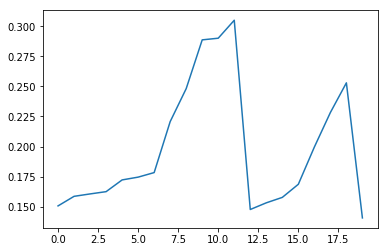

In [307]:
population = Population(100)

for _ in range(20):
    population.selection(verbose=0, threshold=0.11)
    #print('Generation {} complete.'.format(_))

plt.plot(population.average_fitness)

plt.show()


In [243]:

population_size = 20
threshold = 0.1

hosts = [Host() for _ in range(population_size)]
#print(len(hosts))

for _ in range(5):
    fitness_vector = np.zeros(population_size)
    for i,host in enumerate(hosts):
        host.evolve(parasite_seed=10, verbose=0)
        fitness_vector[i] = host.fitness_host
        print(fitness_vector)


    print('Mean fitness: ',np.mean(fitness_vector))

    fitness_vector = np.array([x for x in fitness_vector if  x > threshold])

    cumulative_fitness = np.cumsum(normalize(fitness_vector.reshape(-1,1), axis=0, norm='l1'))

    hosts = [hosts[i].reproduce() for i in cumulative_fitness.searchsorted(np.random.uniform(0, 1, population_size))]
#print(cumulative_fitness.shape)
#print(cumulative_fitness.searchsorted(np.random.uniform(0, 1, population_size)).shape)

# for _ in range(5):
#     next_gen = [hosts[i].reproduce() for i in cumulative_fitness.searchsorted(np.random.uniform(0, 1, population_size))]

#     for i,host in enumerate(next_gen):
#         host.evolve(parasite_seed=10, verbose=0)
#         print(fitness_vector)
#         fitness_vector[i] = host.fitness_host
#     print('Mean fitness: ',np.mean(fitness_vector))

#     fitness_vector = np.array([x for x in fitness_vector if  x > threshold])
    
#     cumulative_fitness = np.cumsum(normalize(fitness_vector.reshape(-1,1), axis=0, norm='l1'))


#plt.show()
# signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
# np.random.choice(signalers)

[0.13479502 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.14594251 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.14594251 0.13479503 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.14594251 0.13479503 0.13479502 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.14594251 0.13479503 0.13479502 0.13625199 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.     

[0.13479502 0.19797216 0.13479502 0.13533528 0.13625199 0.13479502
 0.13479502 0.13479502 0.14594251 0.10518666 0.13533528 0.13479502
 0.17335739 0.21258831 0.19797216 0.10518666 0.18744229 0.25158348
 0.10518666 0.17335739]
Mean fitness:  0.15357341888992068
[0.13479502 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.21258831 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.21258831 0.10518666 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.21258831 0.10518666 0.13479502 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.     

[0.13479502 0.18744229 0.19797216 0.17335739 0.13625199 0.13625199
 0.19797216 0.13479502 0.21258831 0.21258831 0.17335739 0.13479502
 0.17335739 0.13479502 0.13479502 0.21258831 0.10518666 0.19797216
 0.21258831 0.        ]
[0.13479502 0.18744229 0.19797216 0.17335739 0.13625199 0.13625199
 0.19797216 0.13479502 0.21258831 0.21258831 0.17335739 0.13479502
 0.17335739 0.13479502 0.13479502 0.21258831 0.10518666 0.19797216
 0.21258831 0.13479502]
Mean fitness:  0.16691224890370063
[0.13479502 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.17335739 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.17335739 0.21258831 0.         0.         0.
 0.         0.         0.         0.         0.       

In [161]:
print(fitness_vector)
print(normalize(fitness_vector.reshape(-1,1), 'l1', 0))
cumulative_fitness = np.cumsum(normalize(fitness_vector.reshape(-1,1), axis=0, norm='l1'))
print(cumulative_fitness)
print(cumulative_fitness.searchsorted(np.random.uniform(0, 1, population_size)))


#plt.hist(fitness_vector)
#plt.plot(fitness_vector/15)






#np.random.seed(np.random.randint(0,20))

#plt.hist(cumulative_fitness.searchsorted(np.random.uniform(0, 1, 10000)), density=True)

#plt.show()

[0.13533528 0.13533528 0.18300694 0.13533528 0.187234   0.13474112
 0.17438905 0.13291844 0.11143536 0.15180075]
[[0.09134823]
 [0.09134823]
 [0.12352551]
 [0.09134823]
 [0.12637868]
 [0.09094719]
 [0.11770863]
 [0.08971691]
 [0.07521633]
 [0.10246205]]
[0.09134823 0.18269646 0.30622198 0.39757021 0.52394889 0.61489608
 0.73260471 0.82232162 0.89753795 1.        ]
[4 3 6 3 0 8 7 8 4 5]


In [231]:
test = Host()
test.evolve()

Nodes: ['D', 0, 1, 2, 3, 'E', 'P']
Signalers:  [0, 1, 2, 3]
0


Original


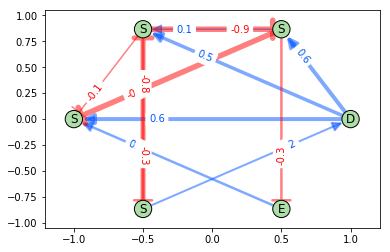

Post-infection


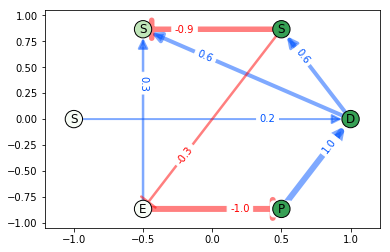

Architecture


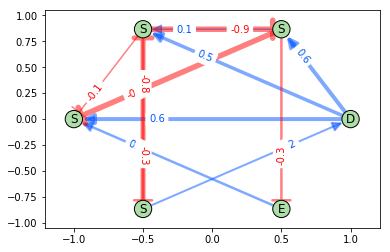

0.1353352832366127
Original


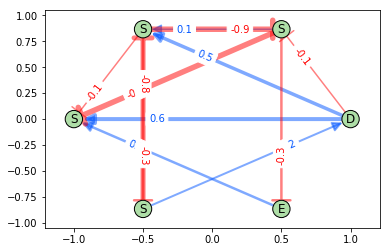

Post-infection


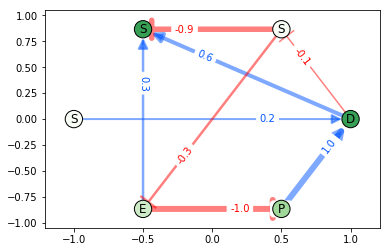

Architecture


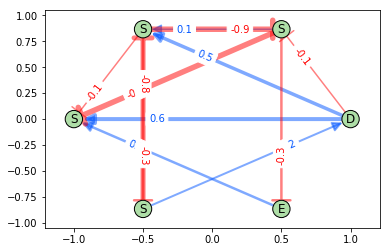

0.16038251467352832


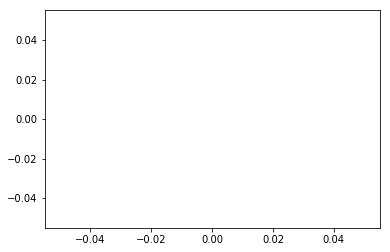

2.446741819381714


In [34]:
#n_nodes = 6

child = Host()


fitness_record = []
start = time()
for _ in range(2):
    print('Original')
    child.visualize()


    child.evolve(parasite_seed=10, verbose=0)
    print('Post-infection')
    child.visualize()
    print('Architecture')
    child.visualize_architecture()
    np.random.seed()
    #fitness_record.append(child.fitness_host)
    if child.fitness_host > 1e-4:
        print(child.fitness_host)
        child = child.reproduce(p_mutation=0.9,verbose=0)
        #child.visualize()
    else:
        'The host died without reproducing'

#child.visualize()

plt.plot(fitness_record)
plt.show()
print(time() - start)



# child.visualize()
# child = child.reproduce(p_mutation=0.9,verbose=1)
# child.visualize()
# child = child.reproduce(p_mutation=0.9,verbose=1)
# child.visualize()
# child = child.reproduce(p_mutation=0.9,verbose=1)
# child.visualize()




#list(net.network.nodes).remove(['D','E'])




#print([type(d['weight']) for u,v,d in net.network.edges(data=True)])



#np.random.choice(net.network.edges())

# edge_index = np.random.randint(0,len(net.network.edges()))
# edge_to_alter = list(net.network.edges())[edge_index]
# net.network.edges[edge_to_alter]['weight'] = np.random.uniform(-1.0,1.0)

#print('...',edge_to_alter)

#for e in net.network.edges():
#    print(net.network.edges[e])



#print(edge_to_remove)
#net.visualize()


# hfitness = []
# pfitness = []

# for _ in range(40):
#     net = Host()

#     net.evolve(seed=10, verbose=0)
# #    net.visualize()
#     hfitness.append(net.fitness_host)
#     pfitness.append(net.fitness_parasite)
#     if net.fitness_parasite > 1: print(net.fitness_parasite)
    
#     if _ % 10 == 0: print((_+10),'% done')

# sns.distplot(hfitness)
# sns.distplot(pfitness)
# plt.xscale('log')
# plt.show()

# print('CI Host: ', np.percentile(hfitness, [2.5,97.5]))
# print('CI Parasite: ', np.percentile(pfitness, [2.5,97.5]))


    #print(net.fitness_parasite)

# for _ in range(1000):
#     net.update()
# net.visualize()

# net.infect()

# print(net.network.nodes['P'])


# net.visualize()

# for _ in range(100):
#     net.update()
# net.visualize()
# print(net.network.nodes)

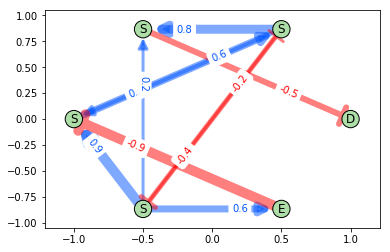

(0.7836720817875342,
 0.30354824786580803,
 -0.38316354575187517,
 -0.46276880384768737,
 0.6085317310864882,
 -0.18043477076739767,
 0.15955452814399318,
 0.8758469587631248,
 0.6486390425279196,
 -0.8594355079729348)

In [1251]:
n_nodes = 6
host_network = nx.binomial_graph(directed=True, n=n_nodes,p=0.5)

#### initialize


for node in host_network.nodes:
    host_network.nodes[node]['active'] = 0.5


for u,v,e in host_network.edges(data=True):
    e['weight'] = np.random.uniform(-1,1)

host_network.remove_edges_from([(0,n_nodes-1),(n_nodes-1,0)])




#### visualize

edges,weights = zip(*nx.get_edge_attributes(host_network,'weight').items())

activating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]
positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]

deactivating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]
negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]

active_ratios = list(nx.get_node_attributes(host_network,'active').values())

pos = nx.shell_layout(host_network)

graph_nodes = nx.draw_networkx_nodes(host_network, node_size=300, pos=pos, alpha=1, 
                       node_color= [a for a in active_ratios],
                                    cmap='Greens', vmin=0, vmax=1.5)  

graph_act_edges =nx.draw_networkx_edges(host_network, edgelist=activating,
                       pos=pos, width=[10*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                        #edge_cmap= plt.cm.Blues, vmax=1, edge_color=positive_weights,
                        alpha=1)

graph_deact_edges = nx.draw_networkx_edges(host_network, edgelist=deactivating,
                       pos=pos, width=[10*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                        #edge_cmap= plt.cm.Reds, edge_color=negative_weights,
                        alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))

letters = ['D']+(host_network.number_of_nodes()-2)*['S']+['E']
labels = dict(zip(host_network.nodes,letters))

nx.draw_networkx_labels(host_network, pos=pos, 
                       labels = labels)
nx.draw_networkx_edge_labels(host_network, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
nx.draw_networkx_edge_labels(host_network, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))


#ax = plt.gca() # to get the current axis

graph_nodes.set_edgecolor('k')

for e in graph_act_edges+graph_deact_edges:
    e.set_alpha(0.5)

plt.show()

weights

In [8]:
dict(list(zip(range(n_nodes), ['D']+list(range(n_nodes-2))+['E'])))

NameError: name 'n_nodes' is not defined

TypeError: Cannot cast array from dtype('float64') to dtype('int64') according to the rule 'safe'

In [1192]:
np.array(['P',2])
#np.random.sample(('P',2))
sorted(('P',2), key=lambda k: np.random.random())

['P', 2]

In [1204]:
net.network.nodes['2']

KeyError: '2'

In [1216]:
int('2')

2

In [1370]:
5e-3

0.005

In [282]:
fitsum = np.array([float(i) for i in '''0.00875713 0.01751427 0.02623806 0.03499519 0.04440789 0.05313007
 0.06188720 0.07310463 0.08382567 0.09116545 0.09949823 0.10822040
 0.11943783 0.12819496 0.13695210 0.14567445 0.15439662 0.16311880
 0.18965121 0.19837338 0.20713473 0.21585691 0.22457908 0.23374919
 0.24247137 0.25119354 0.25991397 0.27113140 0.28296466 0.29168684
 0.30044397 0.30949211 0.32511026 0.33383499 0.34627650 0.35501235
 0.36376948 0.37299702 0.38171919 0.39044136 0.39916354 0.41098009
 0.41851272 0.42723489 0.43595707 0.44467924 0.45343638 0.46219351
 0.47095064 0.50262711 0.51341704 0.52355849 0.53231562 0.54107275
 0.58398120 0.59270337 0.61851905 0.62748883 0.63621101 0.64496814
 0.65372527 0.66244745 0.67120458 0.67904982 0.69122026 0.71532519
 0.72408232 0.73283945 0.74307948 0.75180165 0.76055878 0.76931592
 0.77803809 0.79063231 0.79935448 0.80805205 0.81677423 0.82549640
 0.83421858 0.85766870 0.86639088 0.87431131 0.88209080 0.89426117
 0.91051352 0.92136841 0.93136258 0.94011971 0.95010510 0.95886223
 0.96761914 0.97634131 0.99136729 1.'''.split(r' ')])

In [303]:
np.any(fitsum.searchsorted(np.random.uniform(0, 1, 100000000)) > 93)

False